#load data

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('key')
os.environ["KAGGLE_USERNAME"] = userdata.get('username')


In [ ]:
! kaggle datasets download -d shadabhussain/flickr8k

100% 2.13G/2.13G [01:14<00:00, 33.2MB/s]
100% 2.13G/2.13G [01:14<00:00, 30.7MB/s]


In [ ]:
! kaggle datasets download -d jjentaaw/data-img-cap

100% 46.6M/46.6M [00:02<00:00, 22.0MB/s]
100% 46.6M/46.6M [00:02<00:00, 16.4MB/s]


In [ ]:
!unzip /content/flickr8k.zip

In [ ]:
!unzip /content/data-img-cap.zip

Archive:  /content/data-img-cap.zip
  inflating: captions.npy            
  inflating: image_names.npy         
  inflating: next_words-001.npy      
replace train_encoded_images.p? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# resnet50 + lstm on flickr8k-eng

load lib

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
#from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt

In [ ]:
# Load data
images_dir = os.listdir("/content/flickr_data/Flickr_Data/")

images_path = '/content/flickr_data/Flickr_Data/Images'
captions_path = '/content/flickr_data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
train_path = '/content/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = '/content/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = '/content/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")


In [ ]:
len(x_train), len(x_val), len(x_test), len(captions)

(6001, 1001, 1001, 40461)

In [ ]:
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

In [ ]:
tokens #{img:[caption]}

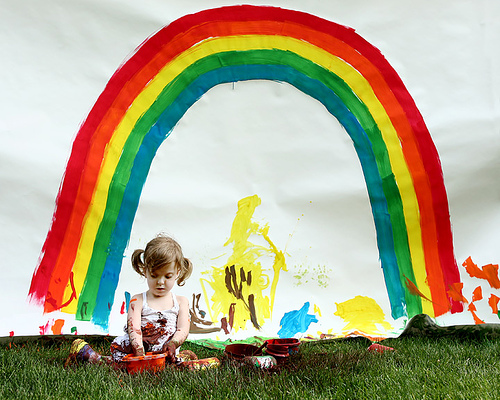

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .


In [ ]:
# displaying an image and captions given to it
temp = captions[10].split("#")
from IPython.display import Image, display
z = Image(filename="/content/flickr_data/Flickr_Data/Images/"+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [ ]:
# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

In [ ]:
# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

In [ ]:
from IPython.core.display import display, HTML
display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
model.summary()

In [ ]:
#ไม่ต้องรัน
def preprocess_img(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [ ]:
#ไม่ต้องรัน
train_data = {}
ctr=0
for ix in x_train:
    if ix == "":
        continue
    # if ctr >= 3000:
    #     break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + "/" + ix
    img = preprocess_img(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred

In [ ]:
#ไม่ต้องรัน
train_data['2513260012_03d33305cf.jpg'].shape

(2048,)

In [ ]:
#ไม่ต้องรัน
len(train_data.keys())

6000

In [ ]:
train_data = {}

In [ ]:
#ไม่ต้องรัน
with open( "/content/train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f )

In [ ]:
pd_dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(30000, 2)


In [ ]:
ds

In [ ]:
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])

print(len(sentences))

30000


In [ ]:
sentences[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

In [ ]:
words = [i.split() for i in sentences]

In [ ]:
#ไม่ต้องรัน
len(words)

30000

In [ ]:
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

8253


In [ ]:
word2index = {val:index for index, val in enumerate(unique)}
index2word = {index:val for index, val in enumerate(unique)}

In [ ]:
word2index['UNK'] = 0
word2index['raining'] = 8253

In [ ]:
index2word[0] = 'UNK'
index2word[8253] = 'raining'

In [ ]:
vocab_size = len(word2index.keys())
print(vocab_size)

8254


In [ ]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


In [ ]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word2index[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool_)

    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1

    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)

#np.unique(padded_sequences)
padded_sequences = np.asarray(padded_sequences, dtype="object")
subsequent_words = np.asarray(subsequent_words, dtype="object")

print(padded_sequences.shape)
print(subsequent_words.shape)

(30000,)
(30000,)


In [ ]:
print(padded_sequences[0])

In [ ]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print(index2word[padded_sequences[0][ix][iy]],)
    print()

print(len(padded_sequences[0]))

In [ ]:
num_of_images = 6000

In [ ]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

In [ ]:
%timeit
for ix in range(num_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])
    if(ix%100==0):
        print(ix)

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

In [ ]:
print(ix)

3003


In [ ]:
captions.shape, next_words.shape

((61491, 40), (61422, 8254))

In [ ]:
np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

In [ ]:
captions[0]

In [ ]:
with open('/content/train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

In [ ]:
ds.shape

(30000, 2)

In [ ]:
encoded_images['1048710776_bb5b0a5c7c.jpg']

dict_keys([b'1048710776_bb5b0a5c7c.jpg', b'1526181215_c1a94325ae.jpg', b'3708839890_ed448012cf.jpg', b'3082934678_58534e9d2c.jpg', b'3126795109_73920ed5dc.jpg', b'3221128704_d1205db79b.jpg', b'3106782647_b078830a9e.jpg', b'710878348_323082babd.jpg', b'2596876977_b61ee7ee78.jpg', b'3381392182_db2c42430e.jpg', b'2824401212_8da8ab99d6.jpg', b'662606040_8cc8cd9f1b.jpg', b'3638783842_af08dbb518.jpg', b'554774472_b5d165ff69.jpg', b'2363540508_9dd1ccf7c7.jpg', b'2315867011_fc5fc9fa6d.jpg', b'747242766_afdc9cb2ba.jpg', b'2834752476_3177e617f1.jpg', b'2988439935_7cea05bc48.jpg', b'3199895624_4f01798c6f.jpg', b'2591455200_2319651f2f.jpg', b'2801851082_8c3c480c0f.jpg', b'534200447_b0f3ff02be.jpg', b'3687995245_624b54090d.jpg', b'2713897716_c8cd610360.jpg', b'3472449219_eb927f05b8.jpg', b'961189263_0990f3bcb5.jpg', b'3419238351_ac18b440c0.jpg', b'2507182524_7e83c6de82.jpg', b'278559394_b23af734b9.jpg', b'143688895_e837c3bc76.jpg', b'3130064588_6d1d3fa2dd.jpg', b'398413603_166896900f.jpg', b'107586

In [ ]:
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0].encode() in encoded_images.keys():
#         print(ix, encoded_images[ds[ix, 0].encode()])
        imgs.append(list(encoded_images[ds[ix, 0].encode()]))

imgs = np.asarray(imgs)
print(imgs.shape)

(15000, 2048)


In [ ]:
!pip install tqdm

In [ ]:
from tqdm import tqdm
images = []

for ix in tqdm(range(6000)):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])

images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)

100%|██████████| 6000/6000 [00:00<00:00, 212171.08it/s]


(76616, 2048)


In [ ]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])

image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)

print(len(image_names))

76616


modellll

In [ ]:
captions = np.load("captions.npy")
next_words = np.load("next_words-001.npy")

print(captions.shape)
print(next_words.shape)

(76616, 40)
(76616, 8254)


In [ ]:
images = np.load("images.npy")

print(images.shape)

(76616, 2048)


In [ ]:
imag = np.load("image_names.npy")

print(imag.shape)

(76616,)


In [ ]:
embedding_size = 128
max_len = 40

In [ ]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVecto  (None, 40, 128)           0         
 r)                                                              
                                                                 
Total params: 262272 (1.00 MB)
Trainable params: 262272 (1.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           1056512   
                                                                 
 lstm (LSTM)                 (None, 40, 256)           394240    
                                                                 
 time_distributed (TimeDist  (None, 40, 128)           32896     
 ributed)                                                        
                                                                 
Total params: 1483648 (5.66 MB)
Trainable params: 1483648 (5.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_input (InputLaye  [(None, 40)]                 0         []                            
 r)                                                                                               
                                                                                                  
 dense_input (InputLayer)    [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 40, 128)              1056512   ['embedding_input[0][0]']     
                                                                                                  
 dense (Dense)               (None, 128)                  262272    ['dense_input[0][0]']     

In [ ]:
hist = model.fit([images, captions], next_words, batch_size=256, epochs=50)

Epoch 1/50
300/300 [==============================] - 10s 33ms/step - loss: 0.4640 - accuracy: 0.8567
Epoch 2/50
300/300 [==============================] - 10s 33ms/step - loss: 0.4634 - accuracy: 0.8558
Epoch 3/50
300/300 [==============================] - 10s 33ms/step - loss: 0.4612 - accuracy: 0.8566
Epoch 4/50
300/300 [==============================] - 10s 33ms/step - loss: 0.4648 - accuracy: 0.8551
Epoch 5/50
300/300 [==============================] - 10s 33ms/step - loss: 0.4586 - accuracy: 0.8569
Epoch 6/50
300/300 [==============================] - 10s 33ms/step - loss: 0.4567 - accuracy: 0.8573
Epoch 7/50
300/300 [==============================] - 10s 33ms/step - loss: 0.4478 - accuracy: 0.8596
Epoch 8/50
300/300 [==============================] - 10s 33ms/step - loss: 0.4476 - accuracy: 0.8608
Epoch 9/50
300/300 [==============================] - 10s 32ms/step - loss: 0.4504 - accuracy: 0.8591
Epoch 10/50
300/300 [==============================] - 10s 33ms/step - loss: 0.448

In [ ]:
model.save_weights("model_weights.h5")

predict

In [ ]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [ ]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [ ]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [ ]:
img = "flickr_data/Flickr_Data/Images/1453366750_6e8cf601bf.jpg"

test_img = get_encoding(resnet, img)

1/1 [==============================] - 1s 967ms/step


In [ ]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2index[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=40, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = index2word[np.argmax(preds[0])]
        start_word.append(word_pred)

        if word_pred == "<end>" or len(start_word) > max_len:
            break

    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

1/1 [==============================] - 0s 23ms/step


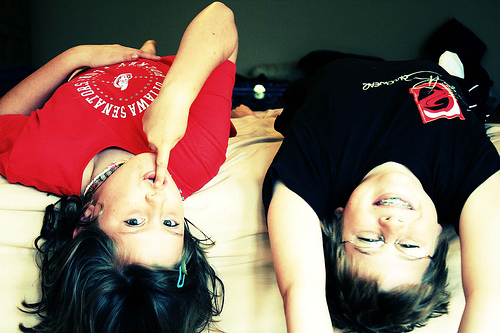

once boxes including Seagulls marker dogsled support goers gap gap gap gap gap gap eyebrow gap gap gap eyebrow gap gap eyebrow gap gap eyebrow gap gap gap eyebrow gap gap eyebrow gap eyebrow eyebrow eyebrow eyebrow gap eyebrow


In [ ]:
from IPython.display import Image, display
z = Image(filename=img)
display(z)

print(Argmax_Search)

# CNN encoder + RNN decoder

## pip yah

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Winmodel/sliced_caption")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences_tokens', 'sentences_raw', 'sentences_sentid', 'cocoid', 'th_sentences_raw'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['image', 'filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences_tokens', 'sentences_raw', 'sentences_sentid', 'cocoid', 'th_sentences_raw'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences_tokens', 'sentences_raw', 'sentences_sentid', 'cocoid', 'th_sentences_raw'],
        num_rows: 1000
    })
})

In [ ]:
train_data = dataset["train"]
val_data = dataset["validation"]
test_data = dataset["test"]

## ไม่ใช้และ

In [ ]:
train_data

Dataset({
    features: ['image', 'filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences_tokens', 'sentences_raw', 'sentences_sentid', 'cocoid', 'th_sentences_raw'],
    num_rows: 6000
})

In [ ]:
len(train_data[0]["th_sentences_raw"][0])

30

In [ ]:
train_data[0]["th_sentences_raw"][0]

'กําแพงมีนาฬิกาและหนังสือมากมาย'

In [ ]:
def make_df(dt):
    return pd.DataFrame({"img":dt["image"], "captionsth":dt["th_sentences_raw"]})

In [ ]:
train_df = make_df(train_data)
val_df = make_df(val_data)
test_df = make_df(test_data)

In [ ]:
def sep_cap(dt):
    imgs = []
    caps = []
    for i in range(len(dt)):
        for j in range(5):
            imgs.append(dt.loc[i, "img"])
            caps.append(dt.loc[i, "captionsth"][j])
    return pd.DataFrame({"images":imgs, "captionth":caps})

In [ ]:
train_df = sep_cap(train_df)

In [ ]:
val_df = sep_cap(val_df)

In [ ]:
test_df = sep_cap(test_df)

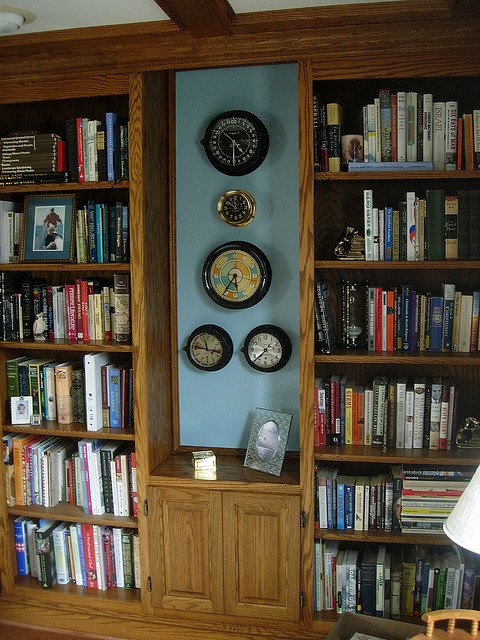

In [ ]:
train_df["images"][0]

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((30000, 2), (5000, 2), (5000, 2))

In [ ]:
img = train_df["images"][0]
arr = np.array(img)
arr.shape

(640, 480, 3)

In [ ]:
def make_pair_img(dt):
    img_ls = []
    for i in range(len(dt)):
        dt["images"][i] = np.array(dt["images"][i])
        img_ls.append()

In [ ]:
def make_img2arr(dt):
    for i in range(len(dt)):
        dt["images"][i] = np.array(dt["images"][i])
    return dt

In [ ]:
train_df = make_img2arr(train_df)

In [ ]:
train_df.shape

(30000, 2)

array([[[129, 135, 133],
        [132, 138, 136],
        [130, 136, 132],
        ...,
        [ 26,  16,   7],
        [ 23,  16,  10],
        [ 25,  20,  16]],

       [[134, 139, 132],
        [133, 138, 131],
        [134, 139, 132],
        ...,
        [ 32,  22,  13],
        [ 31,  22,  17],
        [ 33,  25,  22]],

       [[138, 142, 128],
        [134, 138, 124],
        [137, 141, 127],
        ...,
        [ 34,  21,  13],
        [ 31,  20,  16],
        [ 29,  20,  15]],

       ...,

       [[ 85,  50,  20],
        [ 86,  49,  20],
        [ 86,  45,  17],
        ...,
        [163, 108,  52],
        [165, 113,  56],
        [160, 110,  47]],

       [[ 80,  44,  18],
        [ 80,  43,  17],
        [ 87,  45,  21],
        ...,
        [171, 114,  59],
        [169, 113,  54],
        [168, 113,  49]],

       [[ 83,  47,  25],
        [ 80,  42,  21],
        [ 91,  48,  29],
        ...,
        [160, 103,  48],
        [167, 108,  48],
        [161, 101,  39]]], dtype=uint8)
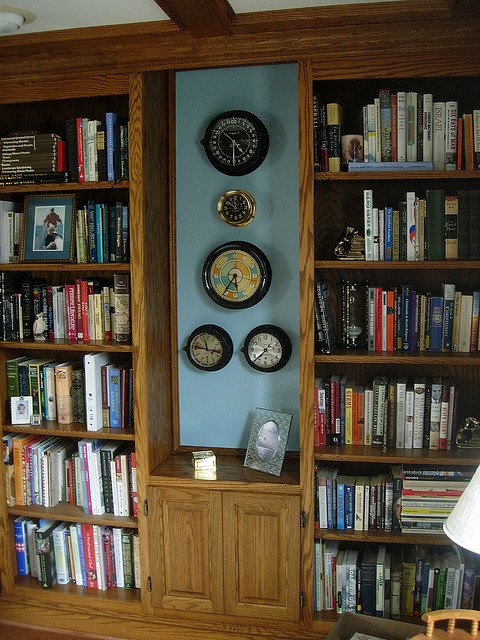

In [ ]:
train_df["images"][0]

In [ ]:
val_df = make_img2arr(val_df)
test_df = make_img2arr(test_df)

In [ ]:
train_df.to_csv("train-mscoco-sepcap.csv", index=False)
val_df.to_csv("val-mscoco-sepcap.csv", index=False)
test_df.to_csv("test-mscoco-sepcap.csv", index=False)

In [ ]:
!nvidia-smi

Sat Apr 20 06:58:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## ใช้อันนี้สิ eiei

In [ ]:
train_data

Dataset({
    features: ['image', 'filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences_tokens', 'sentences_raw', 'sentences_sentid', 'cocoid', 'th_sentences_raw'],
    num_rows: 6000
})

In [ ]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [ ]:
import collections
import pandas as pd

In [ ]:
train_captions = []
img_name_vector = []
for val in zip(train_data['image'],train_data['th_sentences_raw']):
    # print(val[0])
    # print(val[1])
    # break
    for j in range(5):
        train_captions.append(val[1][j])
        img_name_vector.append(np.array(val[0], dtype=np.uint8))

In [ ]:
len(train_captions), len(img_name_vector)

(30000, 30000)

In [ ]:
train_captions[300]

'ผู้ชายบนโทรศัพท์และดื่มด้วยเฉดสีแดงยืนถัดจากผู้หญิง'

In [ ]:
len(np.unique(train_captions))

29575

In [ ]:
train_captions = np.array(train_captions, dtype="object")
img_name_vector = np.array(img_name_vector, dtype="object")

In [ ]:
train_captions.shape, img_name_vector.shape

((30000,), (30000,))

['กําแพงมีนาฬิกาและหนังสือมากมาย' 'เรือนนาฬิกาและหนังสือบางเล่มในห้อง'
 'หนังสือหลายเล่มในห้องสมุดที่บ้าน'
 'มีหนังสือหลายเล่มในห้องนั่งเล่นในเคสหนังสือ'
 'หลายนาฬิกาที่ตั้งอยู่ในหนังสือยืนระหว่างชั้นวางหนังสือ']


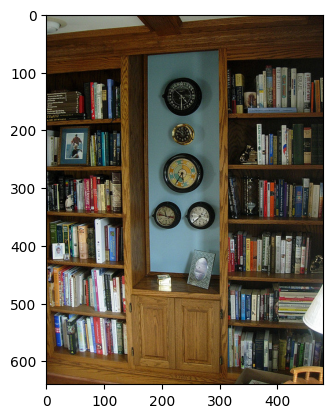

In [ ]:
plt.imshow(img_name_vector[0])
print(train_captions[:5])

## load data

In [ ]:
!wget -c http://images.cocodataset.org/zips/train2017.zip
!wget -c http://images.cocodataset.org/zips/val2017.zip

--2024-04-23 06:39:46--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.24.143, 52.217.226.105, 16.182.66.73, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.24.143|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  47.5MB/s    in 6m 31s  

2024-04-23 06:46:17 (47.1 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2024-04-23 06:46:17--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.10.140, 52.216.136.59, 54.231.160.225, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.10.140|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  47

In [ ]:
!unzip /content/train2017.zip
!unzip /content/val2017.zip

In [ ]:
import json
import pandas as pd

In [ ]:
def json_to_df(json_file_path):
  with open(json_file_path, 'r') as file:
    data = json.load(file)
  rows = []
  for key, descriptions in data.items():
      for description in descriptions:
          rows.append((key, description))
  df = pd.DataFrame(rows, columns=['Image ID', 'Description'])
  train = df[df['Image ID'].str.contains('train2017', regex=False)]
  val = df[df['Image ID'].str.contains('val2017', regex=False)]
  return train, val

In [ ]:
path = "/content/ipu24_v0.4.1_coco.json"
train_df, val_df = json_to_df(path)

In [ ]:
train_df.reset_index(inplace = True)

In [ ]:
train_df

In [ ]:
import collections

In [ ]:
image_path_to_caption = collections.defaultdict(list)
for val in zip(train_df['Image ID'],train_df['Description']):
    PATH = "/content/"
    #caption = f" {val[1]} "
    caption = f"{val[1]}"
    #image_path = PATH + 'images_' + '%012d.jpg' % (val[0])
    image_path = PATH+val[0]+".jpg"
    image_path_to_caption[image_path].append(caption)


In [ ]:
image_paths = list(image_path_to_caption.keys())
#random.shuffle(image_paths)

# Total 8091 images
# Each image has 5 captions
# Total is 40455
train_image_paths = image_paths[:]
print(len(train_image_paths))


114287


In [ ]:

train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

## Inception

In [ ]:
import tensorflow as tf

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
!pip install tqdm

In [ ]:
import numpy as np

In [ ]:
from tqdm import tqdm
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 7143/7143 [22:24<00:00,  5.31it/s]


## text process

In [ ]:
!pip install pythainlp
!pip install stop_words
import pythainlp
from pythainlp import word_tokenize
#from pythainlp.corpus import stopwords
from pythainlp.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
from stop_words import get_stop_words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 51.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=4cc259e3b4761e7c058ec53183400a697960388b6c12e47f82ed4ab045c6723f
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop_words


[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from pythainlp.corpus import thai_stopwords

In [ ]:
print(type(train_captions))
print(len(train_captions))

<class 'list'>
345044


In [ ]:
!pip install pythainlp[attacut]

In [ ]:
from pythainlp.tokenize import word_tokenize
from collections import Counter, OrderedDict
import itertools

In [ ]:
import re
for i in range(len(train_captions)):
    train_captions[i] = re.sub(r',','', train_captions[i])

In [ ]:
thai_texts = []

for line in train_captions:
  thai_text = line.replace('\n','')
  thai_texts.append(thai_text) # Append each sentence to the list

print(thai_texts[0])

ผู้หญิงสวมเสื้อแขนยาวสีขาวและเด็กนั่งเล่นกับสุนัขอยู่ ในสวนหย่อม


In [ ]:
thai_text_tokenizes = []

for i,thai_text in enumerate(thai_texts):
  thai_text_tokenizes.append(word_tokenize(thai_text,engine='newmm')) # tokenize each word
  print(f"{i}/{len(thai_texts)}", end='\r')

In [ ]:
thai_text_tokenizes_merge = list(itertools.chain(*thai_text_tokenizes))
thai_counter = Counter(thai_text_tokenizes_merge)

In [ ]:
thai_vocab_index_to_word = {0:'', 1:''}
thai_vocab_word_to_index = {'':0, '':1}

for i, word in enumerate(thai_counter):
  thai_vocab_index_to_word[i+2] = word # index to word
  thai_vocab_word_to_index[word] = i+2 # word to index

In [ ]:
def convert_sentence_to_index_token(sentence: str):
  word_in_sentence = ['']+ word_tokenize(sentence, engine='newmm') + ['']  # tokenize word in sentence ['cat', 'has']
  word_index = [thai_vocab_word_to_index[word] for word in word_in_sentence] # e.g. cat, thai_vocab[cat] = 2
  return word_in_sentence, word_index

In [ ]:
word_in_sentence, word_index = convert_sentence_to_index_token(train_captions[0])

In [ ]:
for i, word in enumerate(word_in_sentence):
  print(word, word_index[i])

In [ ]:
train_seqs = []
sentence_lis = []
for i in train_captions:
  word_in_sentence, word_index = convert_sentence_to_index_token(i)
  for j, word in enumerate(word_in_sentence):
    sentence_lis.append(word_index[j])
  train_seqs.append(sentence_lis) # [['1','5'],[...],..]
  sentence_lis = []

In [ ]:
print(len(train_seqs))

345044


In [ ]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
top_k = len(thai_vocab_index_to_word.keys())
top_k

17789

In [ ]:
# Pad each vector to the max_length of the captions (to be matrix)
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
print(cap_vector)

[[  1   2   3 ...   0   0   0]
 [  1  16  17 ...   0   0   0]
 [  1  25   6 ...   0   0   0]
 ...
 [  1 605 243 ...   0   0   0]
 [  1  17 517 ...   0   0   0]
 [  1 242  35 ...   0   0   0]]


In [ ]:
cap_vector.shape

(345044, 152)

In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs) #43
print(max_length)

152


In [ ]:
import random

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

len(img_name_train_keys), len(img_name_val_keys)

(91429, 22858)

In [ ]:
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(276034, 276034, 69010, 69010)

## prep data format

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## model yah

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
import tensorflow as tf
class Net(tf.keras.Model):
  """A simple linear model."""

  def __init__(self):
    super(Net, self).__init__()
    self.l1 = tf.keras.layers.Dense(5)

  def call(self, x):
    return self.l1(x)

In [ ]:
net = Net()

In [ ]:
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
    global thai_vocab_word_to_index
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    #hidden = decoder_2.reset_state(batch_size=target.shape[0])
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([thai_vocab_word_to_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
import time

In [ ]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

KeyError: in user code:

    File "<ipython-input-116-46bc73ae6c6e>", line 10, in train_step  *
        dec_input = tf.expand_dims([thai_vocab_word_to_index['<start>']] * target.shape[0], 1)

    KeyError: '<start>'


# tuning llava


## prep data

In [ ]:
!wget -c http://images.cocodataset.org/zips/train2017.zip
!wget -c http://images.cocodataset.org/zips/val2017.zip

--2024-04-24 06:24:02--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.25.164, 52.216.219.177, 54.231.163.121, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.25.164|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  46.9MB/s    in 6m 41s  

2024-04-24 06:30:43 (46.0 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2024-04-24 06:30:43--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.18.148, 52.217.228.217, 3.5.28.125, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.18.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80

In [ ]:
!unzip /content/train2017.zip

In [ ]:
!unzip /content/val2017.zip

In [ ]:
def json_to_df(json_file_path):
  with open(json_file_path, 'r') as file:
    data = json.load(file)
  rows = []
  for key, descriptions in data.items():
      for description in descriptions:
          rows.append((key, description))
  df = pd.DataFrame(rows, columns=['Image ID', 'Description'])
  train = df[df['Image ID'].str.contains('train2017', regex=False)]
  val = df[df['Image ID'].str.contains('val2017', regex=False)]
  return train, val

In [ ]:
import json
import pandas as pd

train_df, val_df = json_to_df("/content/ipu24_v0.4.1_coco.json")

In [ ]:
train_df

Image ID  \
0       train2017/000000373716   
1       train2017/000000373716   
2       train2017/000000373716   
3       train2017/000000196888   
4       train2017/000000196888   
...                        ...   
345157  train2017/000000514668   
345158  train2017/000000514668   
345159  train2017/000000419056   
345160  train2017/000000419056   
345161  train2017/000000419056   

                                              Description  
0       ผู้หญิงสวมเสื้อแขนยาวสีขาวและเด็กนั่งเล่นกับสุ...  
1       สาวคนนึงกำลังพาเด็กมานั่งเล่นอยู่ภายในสนามหญ้า...  
2       ภาพขาวดำ ผู้หญิงนั่งบนพื้นอุ้มเด็กบนตัก ข้าง ๆ...  
3       สีน้ำตาลตัวเล็กกำลังกินอาหารอยู่บนจานกระดาษสีข...  
4       นกน้อยตัวหนึ่งกำลังจิกกินเศษอาหารที่วางทิ้งไว้...  
...                                                   ...  
345157  แมว 2 ตัวที่อยู่ในรถของเจ้าของจอดอยู่ตรงพื้นที...  
345158  แมว 2 ตัว นั่งอยู่ในรถยนต์ ด้านนอกมีภูเขาและท้...  
345159  รถยนต์คันสีดำอยู่ข้างกับเรือลำสีแดงใกล้จะกลับส...  
345160  คนจำนวนหนึ่งที่กำลังเดินข้ามสะพานอยู่ที่สวนสาธ...  
345161  รถสองคันจอดอยู่ใต้สะพานที่มีน้ำเล็กน้อย มีเรือ...  

[345044 rows x 2 columns]

In [ ]:
train_df.iloc[343711]

Image ID                                  train2017/000000287590
Description    หอนาฬิกาสีน้ำตาลนาฬิกาหน้าปัดสีขาวตั้งอยู่กลาง...
Name: 343714, dtype: object

In [ ]:
!pip install tqdm

In [ ]:
from tqdm import tqdm
data = []

for i in tqdm(range(343711)):
    img_path = train_df["Image ID"][i]+".jpg"
    cap = train_df.loc[i, "Description"]
    dictt = {
        "id":str(i+1),
        "image":img_path,
        "conversation":[
            {
                "from": "human",
                "value": "<image>\nอธิบายเกี่ยวกับรูปภาพนี้"
            },
            {
                "from": "gpt",
                "value": cap
            },
        ]
    }
    #print(dictt)
    #break

    data.append(dictt)

100%|██████████| 343711/343711 [00:06<00:00, 54357.71it/s]


In [ ]:
# save data as json
from google.colab import files
import json

with open("prep_train_data_llava.json", "w") as final:
    json.dump(data, final)

files.download('prep_train_data_llava.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## try pure llava

In [ ]:
!conda create -n llava python=3.10 -y
!conda activate llava
!git clone https://github.com/haotian-liu/LLaVA
!cd LLaVA
!pip install --upgrade pip
!pip install -e

/bin/bash: line 1: conda: command not found
/bin/bash: line 1: conda: command not found
fatal: destination path 'LLaVA' already exists and is not an empty directory.

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

-e option requires 1 argument


In [ ]:
import os
!git clone https://github.com/haotian-liu/LLaVA.git
os.chdir("LLaVA")

Cloning into 'LLaVA'...
remote: Enumerating objects: 2291, done.
remote: Counting objects: 100% (799/799), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 2291 (delta 700), reused 643 (delta 637), pack-reused 1492
Receiving objects: 100% (2291/2291), 13.64 MiB | 25.35 MiB/s, done.
Resolving deltas: 100% (1467/1467), done.


In [ ]:
!pip install -Uqqq


!pip -qqq install bitsandbytes accelerate

ERROR: You must give at least one requirement to install (see "pip help install")
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 17.3 MB/s eta 0:00:00


In [ ]:
import torch
from llava.serve.cli import load_image
from llava.constants import IMAGE_TOKEN_INDEX
from llava.model.builder import load_pretrained_model
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria

In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration

model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf")
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")

prompt = "USER: <image>\nอธิบายภาพนี้"
url = "/content/test-img-cap.jpg"
image = Image.open(url)

inputs = processor(text=prompt, images=image, return_tensors="pt")

# Generate
generate_ids = model.generate(**inputs, max_new_tokens=15)
processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


'USER:  \nอธิบายภาพนี้คือคุณมีคุณคุณค'

## load data

In [ ]:
!wget -c http://images.cocodataset.org/zips/train2017.zip
!wget -c http://images.cocodataset.org/zips/val2017.zip

In [ ]:
!unzip /content/train2017.zip
!unzip /content/val2017.zip

## model

In [ ]:
!pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install transformers
!pip install deepspeed
!pip install wandb

In [ ]:
import os
!git clone https://github.com/haotian-liu/LLaVA.git
os.chdir("LLaVA")

fatal: destination path 'LLaVA' already exists and is not an empty directory.


In [ ]:
!pip install git+https://github.com/huggingface/accelerate

In [ ]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model

In [ ]:
model_path = "liuhaotian/llava-v1.5-7b"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=get_model_name_from_path(model_path),
    offload_folder="/content/llava_model",
    device_map="auto"
)

In [ ]:
# Assign paths to variables
DEEPSPEED_SCRIPT = "deepspeed llava/train/train_mem.py"
DEEPSPEED_JSON = "./scripts/zero3.json"
MODEL_NAME = "liuhaotian/llava-v1.5-7b"
DATA_PATH = "/path/to/your/data.json"  # Replace with your JSON data path
IMAGE_FOLDER = "/path/to/your/image_folder"  # Replace with your image folder path
VISION_TOWER = "openai/clip-vit-large-patch14-336"
OUTPUT_DIR = "/path/to/your/output_directory"  # Replace with your desired output directory path

# Preprocess thai food

## load ja

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('key')
os.environ["KAGGLE_USERNAME"] = userdata.get('username')

In [ ]:
!kaggle datasets download -d pes12017000148/food-ingredients-and-recipe-dataset-with-images

 97% 201M/206M [00:07<00:00, 32.7MB/s]
100% 206M/206M [00:07<00:00, 28.5MB/s]


In [ ]:
!unzip /content/food-ingredients-and-recipe-dataset-with-images.zip

## preprocess

In [ ]:
!pip install pythainlp

In [ ]:
!pip install -q sacrebleu==1.2.10 torch pythainlp==2.1.4 mosestokenizer sentencepiece

In [ ]:
!pip install fairseq
!pip install sacremoses sentencepiece
!pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip

In [ ]:
from pythainlp.translate import download_model_all
download_model_all()

# enth = EnThTranslator()

# enth.translate("miso butter roast chicken acorn squash panzanella")

ImportError: cannot import name 'download_model_all' from 'pythainlp.translate' (/usr/local/lib/python3.10/dist-packages/pythainlp/translate/__init__.py)

In [ ]:
df = pd.read_csv('/content/Food Ingredients and Recipe Dataset with Image Name Mapping.csv')

In [ ]:
df

Unnamed: 0                                              Title  \
0               0  Miso-Butter Roast Chicken With Acorn Squash Pa...   
1               1                    Crispy Salt and Pepper Potatoes   
2               2                        Thanksgiving Mac and Cheese   
3               3                 Italian Sausage and Bread Stuffing   
4               4                                       Newton's Law   
...           ...                                                ...   
13496       13496                               Brownie Pudding Cake   
13497       13497  Israeli Couscous with Roasted Butternut Squash...   
13498       13498  Rice with Soy-Glazed Bonito Flakes and Sesame ...   
13499       13499                                        Spanakopita   
13500       13500  Mexican Poblano, Spinach, and Black Bean "Lasa...   

                                             Ingredients  \
0      ['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...   
1      ['2 large egg whites', '1 pound new potatoes (...   
2      ['1 cup evaporated milk', '1 cup whole milk', ...   
3      ['1 (¾- to 1-pound) round Italian loaf, cut in...   
4      ['1 teaspoon dark brown sugar', '1 teaspoon ho...   
...                                                  ...   
13496  ['1 cup all-purpose flour', '2/3 cup unsweeten...   
13497  ['1 preserved lemon', '1 1/2 pound butternut s...   
13498  ['Leftover katsuo bushi (dried bonito flakes) ...   
13499  ['1 stick (1/2 cup) plus 1 tablespoon unsalted...   
13500  ['12 medium to large fresh poblano chiles (2 1...   

                                            Instructions  \
0      Pat chicken dry with paper towels, season all ...   
1      Preheat oven to 400°F and line a rimmed baking...   
2      Place a rack in middle of oven; preheat to 400...   
3      Preheat oven to 350°F with rack in middle. Gen...   
4      Stir together brown sugar and hot water in a c...   
...                                                  ...   
13496  Preheat the oven to 350°F. Into a bowl sift to...   
13497  Preheat oven to 475°F.\nHalve lemons and scoop...   
13498  If using katsuo bushi flakes from package, moi...   
13499  Melt 1 tablespoon butter in a 12-inch heavy sk...   
13500  Lay 4 chiles on their sides on racks of gas bu...   

                                              Image_Name  \
0      miso-butter-roast-chicken-acorn-squash-panzanella   
1             crispy-salt-and-pepper-potatoes-dan-kluger   
2             thanksgiving-mac-and-cheese-erick-williams   
3              italian-sausage-and-bread-stuffing-240559   
4                     newtons-law-apple-bourbon-cocktail   
...                                                  ...   
13496                         brownie-pudding-cake-14408   
13497  israeli-couscous-with-roasted-butternut-squash...   
13498  rice-with-soy-glazed-bonito-flakes-and-sesame-...   
13499                                 spanakopita-107344   
13500  mexican-poblano-spinach-and-black-bean-lasagne...   

                                     Cleaned_Ingredients  
0      ['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...  
1      ['2 large egg whites', '1 pound new potatoes (...  
2      ['1 cup evaporated milk', '1 cup whole milk', ...  
3      ['1 (¾- to 1-pound) round Italian loaf, cut in...  
4      ['1 teaspoon dark brown sugar', '1 teaspoon ho...  
...                                                  ...  
13496  ['1 cup all-purpose flour', '2/3 cup unsweeten...  
13497  ['1 preserved lemon', '1 1/2 pound butternut s...  
13498  ['Leftover katsuo bushi (dried bonito flakes) ...  
13499  ['1 stick (1/2 cup) plus 1 tablespoon unsalted...  
13500  ['12 medium to large fresh poblano chiles (2 1...  

[13501 rows x 6 columns]

# Test pythainlp

In [ ]:
!pip install pythainlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 54.7 MB/s eta 0:00:00


In [ ]:
from pythainlp.spell import correct

correct("แครรอท")

'แครอท'

# posprocess

## pos tagging

### load data

In [ ]:
! pip install -q datasets transformers[sentencepiece] simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 2

In [ ]:
! wget https://github.com/kobkrit/datasets/raw/main/AIFORTHAI-LST20Corpus.tar.gz

--2024-04-23 03:08:14--  https://github.com/kobkrit/datasets/raw/main/AIFORTHAI-LST20Corpus.tar.gz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kobkrit/datasets/main/AIFORTHAI-LST20Corpus.tar.gz [following]
--2024-04-23 03:08:14--  https://raw.githubusercontent.com/kobkrit/datasets/main/AIFORTHAI-LST20Corpus.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13551362 (13M) [application/octet-stream]
Saving to: ‘AIFORTHAI-LST20Corpus.tar.gz’

AIFORTHAI-LST20Corp 100%[===================>]  12.92M  --.-KB/s    in 0.06s   

2024-04-23 03:08:15 (228 MB/s) - ‘AIFORTHAI-LST20Corpus.tar.gz’ save

In [ ]:
! tar -xvzf AIFORTHAI-LST20Corpus.tar.gz

In [ ]:
from datasets import load_dataset
lst20 = load_dataset("lst20", data_dir="/content/LST20_Corpus")

In [ ]:
import pandas as pd
train_df = pd.DataFrame(lst20['train'])
validation_df = pd.DataFrame(lst20['validation'])
test_df = pd.DataFrame(lst20['test'])

In [ ]:
def convert_to_simple_transformer_format(df, field_name, tags):
  sentence_id = []
  words = []
  labels = []

  #Limit at 1000 rows for speed.
  for (idx, r) in df[:10000].iterrows():
    # print(idx)
    for (i, t) in enumerate(r['tokens']):
      # print(i,t)
      sentence_id.append(idx)
      words.append(t)
      labels.append(tags[r[field_name][i]])

  return pd.DataFrame(
      {"sentence_id": sentence_id, "words": words, "labels": labels}
  )


In [ ]:
_POS_TAGS = ["NN", "VV", "PU", "CC", "PS", "AX", "AV", "FX", "NU", "AJ", "CL", "PR", "NG", "PA", "XX", "IJ"]

In [ ]:
train_ = convert_to_simple_transformer_format(train_df, "pos_tags", _POS_TAGS)

In [ ]:
validation_ = convert_to_simple_transformer_format(validation_df, "pos_tags", _POS_TAGS)
test_ = convert_to_simple_transformer_format(test_df, "pos_tags", _POS_TAGS)

In [ ]:
import torch
import pandas as pd
from simpletransformers.ner import NERModel, NERArgs

In [ ]:
# Configure the model
model_args = NERArgs()
model_args.train_batch_size = 32
model_args.evaluate_during_training = True
model_args.overwrite_output_dir = True
model_args.num_train_epochs = 10
model_args.gradient_accumulation_steps = 4

model = NERModel(
    "camembert", "airesearch/wangchanberta-base-att-spm-uncased", args=model_args, use_cuda=torch.cuda.is_available(), labels=_POS_TAGS
)

# Train the model
model.train_model(train_, eval_data=validation_)

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/423M [00:00<?, ?B/s]

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/905k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_model.py:433: UserWarning: use_multiprocessing automatically disabled as CamemBERT fails when using multiprocessing for feature conversion.
  warnings.warn(


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AX seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PU seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarn

Running Epoch 2 of 10:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

(780,
 defaultdict(list,
             {'global_step': [78, 156, 234, 312, 390, 468, 546, 624, 702, 780],
              'train_loss': [0.23938143253326416,
               0.26065924763679504,
               0.10684046894311905,
               0.08225992321968079,
               0.07032372057437897,
               0.09008552879095078,
               0.07227744162082672,
               0.08769158273935318,
               0.07594431936740875,
               0.06592632085084915],
              'eval_loss': [0.2523699878600606,
               0.16345903865600886,
               0.15465604827592247,
               0.14737856453448012,
               0.148735682953868,
               0.14894104108475803,
               0.1498119774879071,
               0.1495008439871303,
               0.15100547841243578,
               0.150638759005488],
              'precision': [0.9122078928368074,
               0.9382784244862834,
               0.94015670342426,
               0.9432830098807456,
  

In [ ]:
import pandas as pd
submit = pd.read_csv("/content/EXP_Number1.csv")

In [ ]:
submit

In [ ]:
submit_rule = submit.copy()

for i in range(48673):
    submit_rule.loc[i, "caption"] = submit_rule.loc[i, "caption"].replace("กำลัง", "")

submit_rule

In [ ]:
submit_rule.to_csv("submit_1_rulebase.csv", index=False)

In [ ]:
!pip install tqdm

In [ ]:
!pip install pythainlp

In [ ]:
def blank_space(x):
  if x == '':
    x = '_'
  return x

In [ ]:
from pythainlp.tokenize import word_tokenize

In [ ]:
def do_pred(raw_sentence):
    words = word_tokenize(raw_sentence, engine="newmm")
    #print(words)
    #print(" ".join(words))
    predictions, raw_outputs = model.predict([" ".join(words)])
    #print(predictions)
    for i in predictions[0]:
        #print(i.keys())
        if(list(i.keys())==["กำลัง"] and i["กำลัง"]=="AX"):
            return True

    return False

In [ ]:
do_pred("ชายสวมเสื้อเชิ้ตสีดำและกางเกงขาสั้นกำลังเล่นเทนนิส")

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

True

In [ ]:

submit_pos = submit.copy()
for i in range(48673):
    cap = submit_pos.loc[i, "caption"]
    #print(cap)
    if(cap.count("กำลัง")!=0):
        if(do_pred(cap)==True):
            submit_pos.loc[i, "caption"] = cap.replace("กำลัง", "")

In [ ]:
submit_pos

NameError: name 'submit_pos' is not defined

In [ ]:
submit_pos.to_csv("submit_1_pos_tag.csv", index=False)

### save model

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
result, model_outputs, preds_list = model.eval_model(test_)

  0%|          | 0/11 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

In [ ]:
import shutil
dir_name = '/content/outputs/best_model'
output_filename = 'pos_model'
shutil.make_archive(output_filename, 'zip', dir_name)

'/content/pos_model.zip'

In [ ]:
from google.colab import files

files.download("/content/pos_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r /content/outputs/best_model /content/gdrive/MyDrive/SuperAIdata

In [ ]:
!pip install huggingface_hub

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

In [ ]:
!huggingface-cli repo create pos_tag_model

git version 2.34.1
git-lfs/3.0.2 (GitHub; linux amd64; go 1.18.1)

You are about to create Madnesss/pos_tag_model
Proceed? [Y/n] y

Your repo now lives at:
  https://huggingface.co/Madnesss/pos_tag_model

You can clone it locally with the command below, and commit/push as usual.

  git clone https://huggingface.co/Madnesss/pos_tag_model



In [ ]:
!git clone https://huggingface.co/Madnesss/pos_tag_model

# Make sure you have git-lfs installed
# (https://git-lfs.github.com/)
!git lfs install

Cloning into 'pos_tag_model'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (3/3), 1.05 KiB | 1.05 MiB/s, done.
Git LFS initialized.


# Usage for posprocess

## นอย

In [ ]:
import pandas as pd
result = pd.read_csv("/content/EXP_Number1.c")

In [ ]:
_POS_TAGS = ["NN", "VV", "PU", "CC", "PS", "AX", "AV", "FX", "NU", "AJ", "CL", "PR", "NG", "PA", "XX", "IJ"]

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -q simpletransformers

In [ ]:
import torch
import pandas as pd
from simpletransformers.ner import NERModel, NERArgs

In [ ]:
ner_args = NERArgs()
ner_args.eval_batch_size = 128
ner_args.use_multiprocessing = True
model = NERModel(
     "auto", " /content/gdrive/MyDrive/SuperAIdata/best_model", args=ner_args, use_cuda=torch.cuda.is_available()
     , labels=_POS_TAGS l
)

## lemma+translate

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

text = "guru99 is a totally new kind of learning experience."
tokens = word_tokenize(text)
lemma_function = WordNetLemmatizer()
for token, tag in pos_tag(tokens):
	lemma = lemma_function.lemmatize(token, tag_map[tag[0]])
	print(token, "=>", lemma)

guru99 => guru99
is => be
a => a
totally => totally
new => new
kind => kind
of => of
learning => learn
experience => experience
. => .


In [ ]:
import pandas as pd

submit = pd.read_csv("/content/test (1).csv")

In [ ]:
submit_lemma = submit.copy()

In [ ]:
submit_lemma

image_id  \
0      test2017/000000160477   
1      test2017/000000386306   
2      test2017/000000502273   
3      test2017/000000480896   
4      test2017/000000228698   
...                      ...   
48668        test/food/07998   
48669        test/food/07999   
48670        test/food/08000   
48671      test/travel/08001   
48672      test/travel/08002   

                                                 caption  
0      a little girl sitting at a table eating a sand...  
1      a street with a yellow fire hydrant and a yell...  
2             a pair of vases with a design on the side.  
3                  a plate of food with a cup of coffee.  
4                a group of people playing a video game.  
...                                                  ...  
48668          a plate of food with rice and vegetables.  
48669                 food on skewers at a street market  
48670                        the nuts are cooked in oil.  
48671                  a clock on the side of a building  
48672                  a cat standing on top of a horse.  

[48673 rows x 2 columns]

In [ ]:
!pip install tqdm

In [ ]:
lemma_function = WordNetLemmatizer()

In [ ]:
from tqdm import tqdm
for i in tqdm(range(48673)):
    cap = submit_lemma.loc[i, "caption"]
    #text = "guru99 is a totally new kind of learning experience."
    tokens = word_tokenize(cap)
    lemma_function = WordNetLemmatizer()
    sent = []
    for token, tag in pos_tag(tokens):
        lemma = lemma_function.lemmatize(token, tag_map[tag[0]])
        sent.append(lemma)
        #print(token, "=>", lemma)
    #print(sent)
    sentences = " ".join(sent)
    #print(sentences)
    submit_lemma.loc[i, "caption"] = sentences

100%|██████████| 48673/48673 [00:39<00:00, 1228.20it/s]


In [ ]:
submit_lemma.head(20)

image_id                                            caption
0   test2017/000000160477      a little girl sit at a table eat a sandwich .
1   test2017/000000386306  a street with a yellow fire hydrant and a yell...
2   test2017/000000502273          a pair of vas with a design on the side .
3   test2017/000000480896             a plate of food with a cup of coffee .
4   test2017/000000228698              a group of people play a video game .
5   test2017/000000227505                      a ship be sail in the ocean .
6   test2017/000000004236  a herd of elephant lay on the grass near a riv...
7   test2017/000000310520      a cat sit in a red chair look at the camera .
8   test2017/000000520985     a table with wine glass and wine glass on it .
9   test2017/000000475126               a row of boat sit on top of a lake .
10  test2017/000000428669      a clock tower with a flag and a flag on top .
11  test2017/000000562562                        the sky be blue and white .
12  test2017/000000468030       a man and a woman stand next to each other .
13  test2017/000000130408           a giraffe standing in a field of grass .
14  test2017/000000296944  a plate of food with carrot , bean , and other...
15  test2017/000000004366  a television in a living room with a chair and...
16  test2017/000000301791    a herd of sheep grazing on a lush green field .
17  test2017/000000321345  a double decker bus be park on the side of the...
18  test2017/000000278707         a bus be drive down the street in a city .
19  test2017/000000376949       a man in black shirt and short play tennis .

In [ ]:
submit_lemma.to_csv("lemma_submit1.csv", index=False)

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

article = "UN Chief says there is no military solution in Syria"
inputs = tokenizer(article, return_tensors="pt")

translated_tokens = model.generate(
    **inputs, forced_bos_token_id=tokenizer.lang_code_to_id["tha_Thai"], max_length=30
)
word = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]
word

'หัวหน้าสหประชาชาติบอกว่า ไม่มีทางแก้ไขทางทหารในซีเรีย'

In [ ]:
submit_tran = submit_lemma.copy()

In [ ]:
from tqdm import tqdm
for i in tqdm(range(48673)):
    article = submit_lemma.loc[i, "caption"]
    inputs = tokenizer(article, return_tensors="pt")

    translated_tokens = model.generate(
        **inputs, forced_bos_token_id=tokenizer.lang_code_to_id["tha_Thai"], max_length=30
    )
    word = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]
    submit_tran.loc[i, "caption"] = word

In [ ]:
submit_tran.to_csv("trans_submit1_lemma.csv", index=False)

# Translation

In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install sacrebleu
!pip install sentencepiece
!pip install sacremoses

In [ ]:
from datasets import load_dataset

# we will choose a target language later, in this part, we need to import the data in the format that it has first
raw_datasets = load_dataset("kde4", lang1="en", lang2="th")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for kde4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/kde4
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
split_datasets = raw_datasets['train'].train_test_split(train_size=0.9, seed = 100)
split_datasets["validation"] = split_datasets.pop("test")

In [ ]:
split_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 63570
    })
    validation: Dataset({
        features: ['id', 'translation'],
        num_rows: 7064
    })
})

In [ ]:
split_datasets['train'][1]

{'id': '40461',
 'translation': {'en': "An error occurred while trying to share folder '%1 '. Make sure that the Perl script'fileshareset' is set suid root.",
  'th': "เกิดข้อผิดพลาดระหว่างปรับให้ใช้โฟลเดอร์ '% 1' ร่วมกัน โปรดตรวจสอบว่า สคริปต์คำสั่งเพิร์ล 'fileshareset' ได้ถูกตั้งให้ประมวลผลโดยใช้สิทธิ์ของ root แล้ว (suid root)"}}

# Tune blip2

## load data

In [ ]:
!wget -c http://images.cocodataset.org/zips/train2017.zip
#!wget -c http://images.cocodataset.org/zips/val2017.zip

--2024-04-24 09:39:28--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.97.249, 54.231.131.153, 3.5.25.76, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.97.249|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [ ]:
!wget -c http://images.cocodataset.org/zips/val2017.zip

--2024-04-24 09:45:53--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.94.4, 3.5.28.204, 52.216.248.76, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.94.4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  47.5MB/s    in 17s     

2024-04-24 09:46:10 (46.2 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [ ]:
!unzip /content/val2017.zip

In [ ]:
!unzip /content/train2017.zip

Archive:  /content/train2017.zip
replace train2017/000000147328.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
def json_to_df(json_file_path):
  with open(json_file_path, 'r') as file:
    data = json.load(file)
  rows = []
  for key, descriptions in data.items():
      for description in descriptions:
          rows.append((key, description))
  df = pd.DataFrame(rows, columns=['Image ID', 'Description'])
  train = df[df['Image ID'].str.contains('train2017', regex=False)]
  val = df[df['Image ID'].str.contains('val2017', regex=False)]
  return train, val

In [ ]:
import json
import pandas as pd

train_df, val_df = json_to_df("/content/ipu24_v0.4.1_coco.json")

## prep data to huggingface

In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write)

In [ ]:
!pip install tqdm

In [ ]:
import datasets
import pandas as pd
from pathlib import Path
from PIL import Image
from transformers import AutoTokenizer
from transformers import Blip2Processor, Blip2VisionModel, Blip2QFormerModel, Blip2QFormerConfig, Blip2ForConditionalGeneration
from transformers import AutoProcessor, Blip2ForConditionalGeneration

import torch

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Expss4/coco_sliced")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'caption'],
        num_rows: 357861
    })
})

In [ ]:
dataset["train"][0]

{'path': 'train2017/000000373716',
 'caption': 'ผู้หญิงสวมเสื้อแขนยาวสีขาวและเด็กนั่งเล่นกับสุนัขอยู่ ในสวนหย่อม'}

In [ ]:
train_ = dataset["train"]

In [ ]:
train_

Dataset({
    features: ['path', 'caption'],
    num_rows: 357861
})

In [ ]:
from tqdm import tqdm
from PIL import Image
imgs = []
texts = []
for i in tqdm(range(357861)):
    base_path = "/content/"
    img_path = base_path+train_[i]["path"]+".jpg"
    img = Image.open(img_path)
    img = img.resize((224,224))
    #print(img)
    imgs.append(img)
    texts.append(train_[i]["caption"])
    #break

100%|██████████| 357861/357861 [01:23<00:00, 4290.13it/s]


In [ ]:
len(texts)

357861

In [ ]:
import numpy as np
imgs_arr = np.array(imgs)
np.save('resized_imgs.npy', imgs_arr)

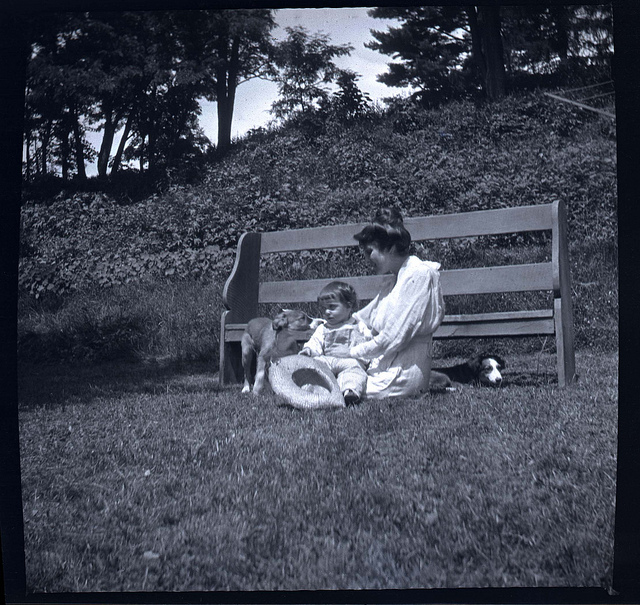

In [ ]:
imgs[0]

In [ ]:
dataset = datasets.Dataset.from_dict({"image": imgs, "text": texts})

In [ ]:
dataset = dataset.train_test_split(test_size=0.25, seed=888)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", load_in_8bit=True)

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.1398


In [ ]:
train_dataset = ImageCaptioningDataset(dataset['train'], processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4, collate_fn=collate_fn)

In [ ]:
test_dataset = ImageCaptioningDataset(dataset['test'], processor)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=4, collate_fn=collate_fn)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import torch
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()

for epoch in tqdm(range(1)):
    print("Epoch:", epoch)
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss
        if(idx%1000==0):
            print("idx", idx)
            print("Loss:", loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    model.push_to_hub("Madnesss/blip2-lora-coco2017-th")

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0
idx 0
Loss: 1.826171875


  0%|          | 0/1 [08:34<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# ไถ with code posprocess

In [ ]:
import pandas as pd

In [ ]:
sub_df = pd.read_csv("/content/exp-1.csv")

In [ ]:
# delete some trash

In [ ]:
!pip install tqdm

In [ ]:
sub_df

image_id  \
0      test2017/000000160477   
1      test2017/000000386306   
2      test2017/000000502273   
3      test2017/000000480896   
4      test2017/000000228698   
...                      ...   
48668        test/food/07998   
48669        test/food/07999   
48670        test/food/08000   
48671      test/travel/08001   
48672      test/travel/08002   

                                                 caption  
0      เด็กผู้หญิงชาวต่างชาติ กำลังถือขนมเพือกิน โดยท...  
1      เป็นย่านขายของริมถนนซึ่งมีป้ายภาษาจีนติดยื่นออ...  
2      มีแจกันสองใบ ใบทางขวามีลายกราฟิกสีเขียวส้มดำแล...  
3                                         จานอาหารบนโต๊ะ  
4                          กลุ่มคนในห้องที่มีคอมพิวเตอร์  
...                                                  ...  
48668                                     ผัดไทยหนึ่งจาน  
48669                อาหารที่หรือที่ไหนสักแห่งใกล้โรงแรม  
48670                                ไก่ปรุงในหม้อใบใหญ่  
48671                                  หอนาฬิกาหน้าอาคาร  
48672                                แมวยืนอยู่บนหลังม้า  

[48673 rows x 2 columns]

In [ ]:
from tqdm import tqdm

In [ ]:
def remove_trash(capp):
    capp = capp.replace("[ ไม่ได้ใช้0 ]", "")
    capp = capp.replace("` `", "")
    capp = capp.replace("นั้น", "")
    capp = capp.replace(" : ", "และ")
    capp = capp.replace("#", "")
    capp = capp.replace(" - - ", "")
    capp = capp.replace("- 0.00 -", "")
    capp = capp.replace("(หรืออันดับ)", "")
    capp = capp.replace("และ", " ")
    capp = capp.replace("แล้ว", " ")

    return capp

In [ ]:
def space_la(capp):
    if("และ" in capp):
        idx = capp.index("และ")
        prev = capp[:idx]
        poss = capp[idx+3:]
        new_cap = prev.strip()+"และ"+poss.strip()
        return new_cap
    return capp

In [ ]:
space_la("ถนนในเมืองอันพลุกพล่านพร้อมสัญญาณไฟจราจร  รถเครน และ")

'ถนนในเมืองอันพลุกพล่านพร้อมสัญญาณไฟจราจร  รถเครนและ'

In [ ]:
for i in tqdm(range(3, 48673)):
    #replace
    cap = space_la(sub_df.loc[i, "caption"])
    sub_df.loc[i, "caption"] = cap


100%|██████████| 48670/48670 [00:05<00:00, 8793.51it/s] 


In [ ]:
sub_df.to_csv("submit_la_nospace.csv", index=False)

In [ ]:
!wget -c http://images.cocodataset.org/zips/test2017.zip

--2024-04-25 05:04:17--  http://images.cocodataset.org/zips/test2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.161, 52.216.210.209, 3.5.25.210, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6646970404 (6.2G) [application/zip]
Saving to: ‘test2017.zip’

test2017.zip        100%[===================>]   6.19G  46.9MB/s    in 2m 20s  

2024-04-25 05:06:37 (45.3 MB/s) - ‘test2017.zip’ saved [6646970404/6646970404]



In [ ]:
!unzip /content/test2017.zip

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
 extracting: test2017/000000251604.jpg  
 extracting: test2017/000000145034.jpg  
 extracting: test2017/000000234833.jpg  
 extracting: test2017/000000025927.jpg  
 extracting: test2017/000000393116.jpg  
 extracting: test2017/000000536478.jpg  
 extracting: test2017/000000365460.jpg  
 extracting: test2017/000000089887.jpg  
 extracting: test2017/000000274928.jpg  
 extracting: test2017/000000310028.jpg  
 extracting: test2017/000000229793.jpg  
 extracting: test2017/000000394339.jpg  
 extracting: test2017/000000564538.jpg  
 extracting: test2017/000000440585.jpg  
 extracting: test2017/000000541512.jpg  
 extracting: test2017/000000395525.jpg  
 extracting: test2017/000000235435.jpg  
 extracting: test2017/000000069964.jpg  
 extracting: test2017/000000131962.jpg  
 extracting: test2017/000000281392.jpg  
 extracting: test2017/000000534893.jpg  
 extracting: test2017/000000128676.jpg  
 extracting: test2017/000000187639.jpg  


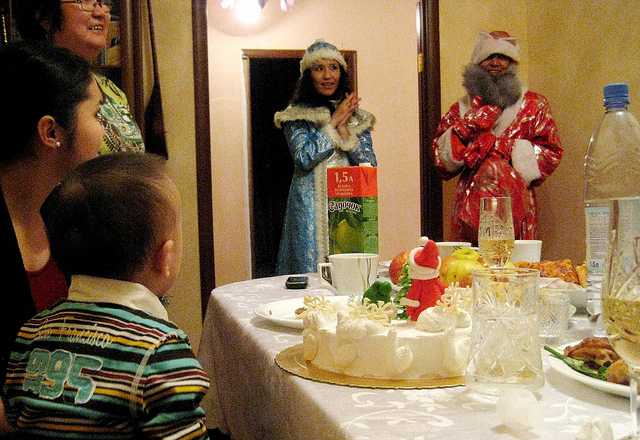

In [ ]:
from PIL import Image
img = Image.open("/content/test2017/000000108131.jpg")
img

# translation

In [ ]:
!pip install transformers

In [ ]:
!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 7.6 MB/s eta 0:00:00


In [ ]:
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer

en_text = ["a little girl sit at a table eat a sandwich"]
thai_text = "ฉันเคยเป็นแครรอท"

tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M", src_lang="en")
model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M")

In [ ]:
encoded_zh = tokenizer(en_text, return_tensors="pt", padding=True)

In [ ]:
generated_tokens = model.generate(**encoded_zh, forced_bos_token_id=tokenizer.get_lang_id("th"))
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

['หญิงที่นั่งที่โต๊ะกิน sandwich']

In [ ]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

article_en = "a little girl sit at a table eat a sandwich"

model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

# translate Hindi to French
tokenizer.src_lang = "en"
encoded_hi = tokenizer(article_en, return_tensors="pt")
generated_tokens = model.generate(
    **encoded_hi,
    forced_bos_token_id=tokenizer.lang_code_to_id["th_TH"]
)
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)


['little teen teen teen teen teen teen teen teen teen teen little little little little girl girl girl girl girl sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit sit']

In [ ]:
from transformers import pipeline

pipe = pipeline("translation_en_to_th", model="google/madlad400-3b-mt")
pipe("Let's go to france and see the eiffel tower")

config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/11.8G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
!pip install --quiet git+https://github.com/huggingface/transformers sentencepiece

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torchaudio
from transformers import AutoProcessor, SeamlessM4TModel
processor = AutoProcessor.from_pretrained("facebook/hf-seamless-m4t-medium")
model = SeamlessM4TModel.from_pretrained("facebook/hf-seamless-m4t-medium")


preprocessor_config.json:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.33k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.29k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/2.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/5.35k [00:00<?, ?B/s]

In [ ]:
from transformers import SeamlessM4Tv2Model, AutoProcessor
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("facebook/seamless-m4t-v2-large")
model = SeamlessM4Tv2Model.from_pretrained("facebook/seamless-m4t-v2-large")


/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.17M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.34k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/2.72k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/211k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.24G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/9.91M [00:00<?, ?B/s]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [ ]:
import torch

In [ ]:
# process input
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_inputs = processor(text = ["Hello, my dog is cute", "Hello, my cat is cute"], src_lang="eng", return_tensors="pt").to("cuda")

# generate translation
# output_tokens = model.generate(**text_inputs, tgt_lang="tha", generate_speech=False)
# translated_text_from_text = processor.decode(output_tokens[0].tolist()[0], skip_special_tokens=True)
# print(f"Translation from text: {translated_text_from_text}")

In [ ]:
output_tokens

In [ ]:
# generate translation
output_tokens = model.generate(**text_inputs, tgt_lang="tha", generate_speech=False)
output_tokens
# translated_text_from_text = processor.decode(output_tokens[0].tolist()[0], skip_special_tokens=True)
# print(f"Translation from text: {translated_text_from_text}")

In [ ]:
translated_text_from_text = processor.decode(output_tokens[0].tolist()[1], skip_special_tokens=True)
translated_text_from_text

'สวัสดีครับ แมวของฉันน่ารัก'

In [ ]:
!pip install tqdm

In [ ]:
sub_mit

image_id                                         caption
0      test2017/000000160477  a little girl is eating a sandwich at a table.
1      test2017/000000386306         a street with signs and buildings on it
2      test2017/000000502273     a pair of vases sitting next to each other.
3      test2017/000000480896                     a plate of food on a table.
4      test2017/000000228698     a group of people in a room with computers.
...                      ...                                             ...
48668        test/food/07998                     a plate of pad thai noodles
48669        test/food/07999             food at or somewhere near the hotel
48670        test/food/08000           the chicken is cooked in a large pot.
48671      test/travel/08001           a clock tower in front of a building.
48672      test/travel/08002               a cat standing on top of a horse.

[48673 rows x 2 columns]

In [ ]:
cap_ls[0]

'a little girl is eating a sandwich at a table.'

In [ ]:
import pandas as pd

In [ ]:
from tqdm import tqdm

for i in tqdm(range(48673)):
    text_inputs = processor(text = cap_ls[i], src_lang="eng", return_tensors="pt").to("cuda")
    output_tokens = model.generate(**text_inputs, tgt_lang="tha", generate_speech=False)
    translated_text_from_text = processor.decode(output_tokens[0].tolist()[0], skip_special_tokens=True)

    sub_mit.loc[i, 'caption'] = translated_text_from_text

100%|██████████| 48673/48673 [2:44:39<00:00,  4.93it/s]


In [ ]:
sub_mit.to_csv("submission_trans.csv", index=False)

In [ ]:
sub_mit = pd.read_csv("/content/test6_1.csv")

In [ ]:
sub_mit

In [ ]:
cap_ls = list(sub_mit["caption"])
type(cap_ls)

list

In [ ]:
cap_ls

In [ ]:
text_inputs = processor(text = cap_ls[0], src_lang="eng", return_tensors="pt").to("cuda")

In [ ]:
output_tokens = model.generate(**text_inputs, tgt_lang="tha", generate_speech=False)
#output_tokens

In [ ]:
translated_text_from_text = processor.decode(output_tokens[0].tolist()[0], skip_special_tokens=True)
translated_text_from_text

'เด็กผู้หญิงน้อยกําลังกินแซนวิชที่โต๊ะ'